# Scraping Multiple Pages

Large scale web scraping can sometimes require us to do a different kind of "pagination" in order to visit multiple links on a page and extract some text or data from each one. For instance: [this URL](https://lite.cnn.com/) has a list of top stories from CNN.com and hyperlinks to (a minimal HTML version of) each article.

In [185]:
from requests import get
import pandas as pd
import time
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import re


In [186]:
site = get('https://lite.cnn.com/')
content = BeautifulSoup(site.content, 'html.parser')

I can use the Selector Gadget to find a selector expression that grabs all of these headlines, or I can try to create one by examining the HTML of the site. Remember the goal here is to find an expression that uniquely identifies the elements we want

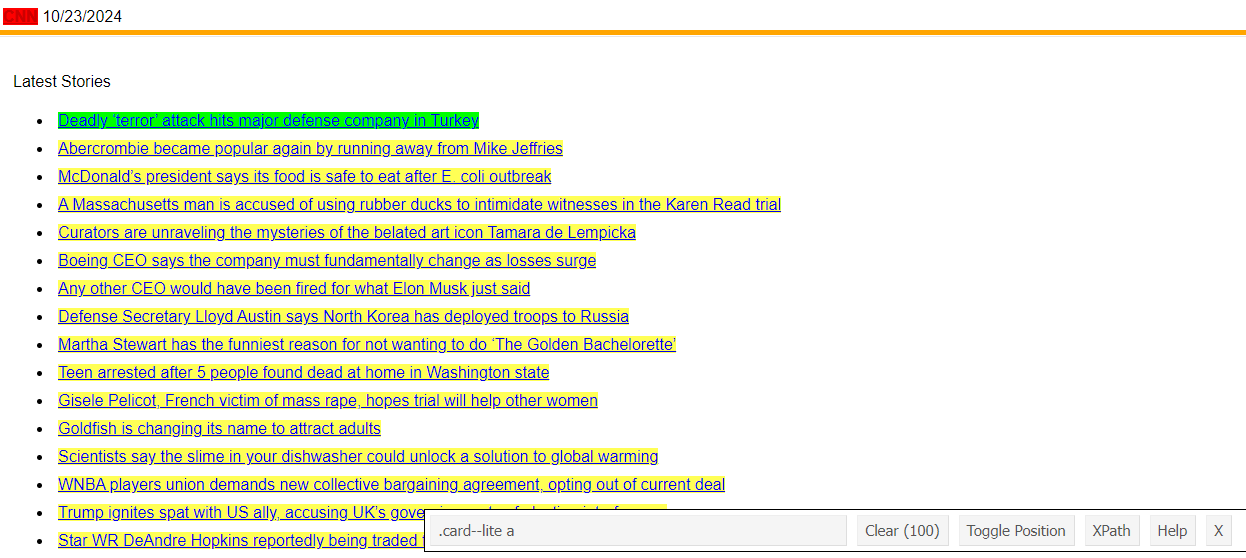

Alternatively, I can look at the HTML on this page to come up with my selector expression. I can see that the headlines on this page are nested inside of  `<a>` tags that are nested inside of `<li>` tags with a class of "card lite". The selector expression ".card--lite a" translates to "Retrieve all the the `<a>` tags that are nested in a tag with a `"card--lite"` class"

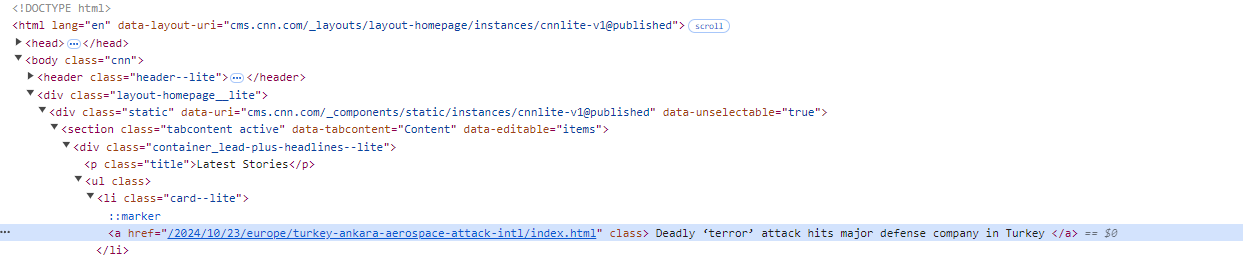

I can grab all of the headlines with this expression:

In [ ]:
headlines = content.select('.card--lite a')

Looking at the first element, I can see that the headlines are inside of the `<a>` tags and the url is in an `href` attribute

In [ ]:
headlines[0]

I can retrieve an attribute value with the `get` method and I can get the text inside of a tag with `get_text`. I'll just use a couple of list comprehensions to iterate over this list of HTML elements and extract the full text and URL, then place the results in a data frame

Finally, we'll need to turn these relative URLs into absolute URLs by appending the URL of the current page. We can do this automatically with a `urljoin` expression.


| Domain       | Path                                                              | Absolute URL                                                                          |
|--------------|-------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| lite.cnn.com | /2024/10/23/europe/turkey-ankara-aerospace-attack-intl/index.html | https://lite.cnn.com/2024/10/23/europe/turkey-ankara-aerospace-attack-intl/index.html |

In [ ]:
fmted_result ={'link' : [urljoin(site.url, i.get('href')) for i in headlines],
               'headline_text' : [i.get_text().strip() for i in headlines]}

article_df = pd.DataFrame(fmted_result)
article_df.head()

On its own, this list of links isn't very useful. More often I'll want to get the actual article text as well. To do that, I would need to write a loop that visits each page and stores the HTML, then extract the full text, author information etc. from each page

For the sake of this example, I'll just take the first five headlines here. Once we've got code that works, we can easily re-run this loop on the entire list of headlines


In [ ]:
# taking the first 5 rows just for this example 
article_sample = article_df[:5]

In [ ]:
article_sample.loc[1, 'link']

<b style="color:red;">
<h3>Question 1A</h3>
Write a loop to get a response object from each page in the sample of articles. Make sure to put a `time.sleep` call in your loop to put a short rest between each request
</b>

Hint: since you already know exactly how many URLs you need to visit, you can use a `for` loop instead of a `while` loop here.


In [ ]:
# a loop to get responses from each link


<b style="color:red;">
<h3>Question 1B</h3>
Write a function that takes a single response and returns a dictionary with the full text, article author, publication date and url from each. Call the function <code>cnn_parser</code>
</b>
<div class="alert alert-block alert-info">
<b>Tip 1:</b> 
Remember that you can get the url from a response object with <code>resp.url</code>
<br>
<b>Tip 2:</b> 
Note that you you'll probably need to concatenate multiple strings into one long string of text. You can paste text together with a <code>join</code> function like:

<code>`' '.join(string_list)`</code>
</div>



Remember that the easiest way to approach this is to start with a single response and write code to parse it, then wrap your code in a function declaration:

In [ ]:
# get a single response
resp = articles_list[0]

# write code to parse it and put it in a dictionary
soup  = BeautifulSoup(resp.content)
parsed_result = # .... 


In [ ]:
# then wrap the code you used above in a function definition that takes "resp" 
# as an argument and returns "parsed_result"
def cnn_parser(resp):
   
    return parsed_result

Once you have a function that can work on a single result, you can create a DataFrame like this: 

In [ ]:
cnn_df = pd.DataFrame([cnn_parser(i) for i in articles_list])
cnn_df.head()

Since you already included the link each each column, you can join with with the data frame with headlines using a `merge`

In [ ]:
cnn_df_full = cnn_df.merge(article_sample, on ='link')
cnn_df_full.head()

### Storing and re-using the result
When we're done, it might be a good idea to save a copy of our results to a file so we can work with it later. This is especially true when we're running code that sends a lot of requests: the python environment is cleared when we quit, so we don't want to have to re-send the same queries every single time we re-open the program

We can use the `.to_csv` method to store a result as a csv file. After running this you should see a file called `cnn_articles` in your working directory

In [ ]:
# usually set index=False to avoid writing the index names as a new column
cnn_df_full.to_csv('cnn_articles.csv', index=False)

If you want to restore this data, then you would just run

In [ ]:
arts = pd.read_csv("cnn_articles.csv")
arts.head()

<div class="alert alert-block alert-danger">
⚠️ If you already have a file called <code>cnn_articles.csv</code> in your working directory, then running this code again will overwrite it. In many cases, this is what you want, but you should be careful to avoid accidentally overwriting existing data. Setting `mode='x'` will cause this function to fail instead of overwriting an existing file. So consider using that.
</div>


## Using a sitemap

Larger sites will usually have a sitemap that acts as a map of URLs to make it easier to web crawlers to index pages. If its available, you can usually locate a page's sitemap by navigating to `[domain name here]/robots.txt`. For instance, the `robots.txt` page for `apnews.com` is `https://apnews.com/robots.txt`. If you go to that URL, you'll see a section of sitemaps. If you go to that URL and then follow the first link to https://apnews.com/ap-sitemap.xml, you'll end up on a page that looks like this:

This is a .xml formatted document, which you might notice looks pretty similar to the .html code we've viewed in the past. We won't be able to use the SelectorGadget on these pages, but we will be able to use BeautifulSoup to parse it and extract information using expressions that are very similar to the ones we use to parse an HTML document



Following one of the links on this page will take you to another sitemap listing all of the AP articles published for a single month. So you can think of the structure of this site as sort of following a hierarchy like this:

<img src="https://mermaid.ink/img/pako:eNpl0UFrwjAUB_CvEt7Ziu10sB4G1U5QcJftZnZ4tK820DQlfcUN8bsvRgkt5pT88s__kHeBwpQEKVSNORc1WhbfuWyFW_kRu6hXTBq7-a9ufkQUvYtspFGySJbx4s3f3h9lPvRxzCyroiERT3wbPHl4fuP1c-eo0kc2T5F4FFn79l1of5n4Pvjy4Rvvh-CriX8Gf3UOM9BkNarS_dLllpPANWmSkLptZSz1LEG2V5fEgc3XX1tAynagGVgznGpIK2x6dxq6EplyhSeLOiiVio093Mfgp3H9Bz2retE?type=png" width="500" height="100" />




We'll pull a single sitemap for a single month, but note that you could easily write a loop to navigate through every sitemap and extract every link. Go ahead and take a look at the map for <a href=https://apnews.com/ap-sitemap-202410.xml>stories from October 2024 here</a> (this will probably load slowly!)

In [ ]:
# get the sitemap
october_sitemap = get('https://apnews.com/ap-sitemap-202410.xml')

This sitemap has links for October 2024. We'll parse it as an `xml` document, then we'll use a simple selector expression to grab all of the links.

In [ ]:
# parse the content as an XML document
sitemap= BeautifulSoup(october_sitemap.content, features="xml")


In [ ]:
# select all <loc> nodes
url_nodes = sitemap.select('loc')

# loop through the entire list and just get the link
urls = [i.get_text() for i in url_nodes]
urls[:10]

The links here contain a bunch of different article types, but maybe I only want the articles and not any of the links to video links or 'hubs'. 

I can use a regular expression to detect the urls that have "article" as part of their path and create a list with exclusively "article" links:

In [ ]:
article_urls  = [i for i in urls if bool(re.search("/article/", i)) ]


Now we need a loop to iterate through the links and create a list of responses. There's a few thousand links here, so we're just going to grab the first 10 for this example

In [ ]:
articles_list = []
# we're only looping through 10 articles here, obviously we could do a lot more
for i in article_urls[:10]:
    # you can add a print statement like this to track the progress of your loop:
    print(i, end='\r')
    article_resp = get(i)
    # append the response to the list
    articles_list.append(article_resp)
    time.sleep(1)



And we need a function to parse a single result and store some relevant information in a dictionary:

In [ ]:
def article_parser(resp):
    article= BeautifulSoup(resp.content)
    # 
    article_info = {
        'url' : resp.url,
        # headline 
        'headline': ' '.join([str(i.get_text()) for i in article.select("h1.Page-headline")]),
        # full text
        'fulltext':' '.join([str(i.get_text()) for i in article.select(".Page-storyBody p")]),
        # bylines (comma separated for multiple authors)
        'byline':', '.join([str(i.get_text()) for i in article.select(".Page-authors span")]),
        # first updated date
        'date' : min([pd.to_datetime(int(i.get('data-timestamp')), unit='ms') for i in article.select('bsp-timestamp')])
    }
    return article_info

We can construct our data frame by applying the `article_parser` function to each element in articles list, and then using `pd.DataFrame` to make it into a data frame

In [ ]:
articles_df = pd.DataFrame([article_parser(i) for i in articles_list])
articles_df.head()

Finally, we can save our results to a .csv file for future use.

In [ ]:
articles_df.to_csv('ap_articles.csv', index=False)

This example just parsed a sitemap for a single month. If you were doing this for a larger project, you might want to get links for multiple months of AP articles. But we already have the basic building blocks we need to do that because we have a series of sitemaps that gives us the structure of the site. 

# Managing larger projects
<a id='managing'></a>

Up to now, we've mostly run all of our analyses in a single notebook file. This is fine for quick analysis, but when we start to assemble larger projects, we'll often want to maintain multiple scripts or notebooks to help us organize and separate our code. Whether and how you choose to do this is a matter of personal judgement. However, whatever you choose to do, all the code needed to replicate your analysis should be saved somewhere along with comments or written instructions on how you did things. 






### Separating your code and saving results

If we're just sending a couple API requests or scraping a single page, it often makes sense to do this "in memory": we scrape a page or send a request to an API, store the results in a Python variable, and run our analyses. The results of our analyses will go away whenever we exit Python, but we can just re-run the request next time we open open Python. This is fine for small-scale analysis, but, when we have code that sends a lot of requests, we probably don't want to have to re-run that over and over again. In those cases we probably want to write a separate script that collects our data and then saves the results to a file. Then we can just re-load that file next time we open Python

For instance, rev.com has transcriptions of speeches from the 2024 presidential campaign. I want to scrape the full text of each speech. There are about 200 separate pages with transcripts, and I put a short pause of 1 second between each request, so this takes over 3 minutes to run. I don't want to do this every time I open Python, so I wrote a separate script called `speeches_scraper.py` that does the data collection and stores the results in a .csv. Then I can reload that data by running  `pd.read_csv` at the top of my script:




In [ ]:
import pandas as pd
speeches = pd.read_csv("extra_code/speeches.csv")
speeches.head()

When/whether it makes sense to separate code this way is often a matter of personal judgement, but if it takes more than a few seconds to run and you don't need/want the data to update, then this is probably your best option

If you've written a Python script in a separate file, you can call it directly from within a Jupyter notebook using the `%run` magic command.

Here's an example of conditionally running our scraper script from within a jupyter notebook. This code runs if the "speeches.csv" file doesn't exist in the current working directory, otherwise, it skips this script. 

In [ ]:
import os.path
if os.path.isfile('extra_code/speeches.csv') == False:
    print("speeches file doesn't exist, creating")
    %run ./extra_code/pres_speeches.py
else:
    print("file already exists. Skipping")


### Creating a functions file

Another scenario where we might want to keep separate files is when we have a lot of function definitions that get re-used throughout our analysis and we want to avoid cluttering a written report.

For instance, I've written a couple of functions for working with the congress.gov API. The `member_parser` function takes a response from the members endpoint and re-formats it as a dataframe. The `congress_paginate` function takes an initial requests and then automatically paginates until it gets a complete list of results from the API. Instead of including those functions in this document, I've placed them in a separate file and then I make them available in this notebook by using the same `import` function that we use to import modules. 

`import extra_code.congress_api_functions as cong` will go into the `extra_code` directory and look for a script called `congress_api_functions` and then run that script and make its functions available. 

<div class="alert alert-info">Note: this code assumes you've got a Congress.gov API key and stored it in a file called <code>congress_gov.txt</code> inside the <code>extra_code</code> directory. 
    
You can sign up for an API key here: https://gpo.congress.gov/sign-up/</div>


In [2]:
# import my custom functions: 
#from extra_code.congress_api_functions import congress_paginate, member_parser
import extra_code.congress_api_functions as cong
# import the congress API key
with open('extra_code/congress_gov.txt', 'r') as f:
    congress_key = f.readline()

# the members endpoint
member_url = 'https://api.congress.gov/v3/member'
# my additional parameters: 
congress_parameters = {'currentMember': 'true',
                       'page':'1',
                       'limit': 250,
                       'api_key':congress_key}
# running the pagination function:
responses_list = cong.congress_paginate(member_url, params= congress_parameters)

In [ ]:
# iterate over the list of responses, parse each one, and then create a single concatenated data frame: 
member_frame = pd.concat([member_parser(i) for i in responses_list])
# look at the first few results: 
member_frame.head()

As with the previous example, the decision to organize code this way is largely a matter of personal judgement. The main disadvantage of this approach is that it can make it harder for people to understand what your code is doing. On the other hand, it can make our notebook file more concise. 

Another advantage is that, if I'm writing multiple analyses that all require this set of functions, I can maintain a single functions file and the import a copy to each of my analyses. This helps me avoid writing redundant code, and it also makes it a lot easier to make modifications or correct errors in my functions since I only need to edit a single file instead of three.


<img src='https://mermaid.ink/img/pako:eNp9z7EKwjAQBuBXCTcp1EHdMghq1051Mw5HcmkDbVLSC1JK392odNSb7uD74f4ZdDAEEmwXnrrFyOJWKi_ylJtqEjZ5zS74cSt2u5M432sd3cBi__iNLis6_EHXFR0zggJ6ij06kz-Z3yEF3FJPCmReDVlMHStQfskUE4d68hokx0QFxJCaFqTFbsxXGgwylQ6biP1KyDgOsfpW_TReXqr4UPs?type=png'>Theoretical organization of a project with multiple analysis scripts importing custom functions from a single python script</img>

## Installing Additional Packages

We've only used packages that were already available and installed in our BSOS JuypterHub environment so far. However, you might want to use packages that aren't already installed (or you might want to have JupyterLab on your own computers and need to install them yourself). To do this within Jupyter, you can use the ! notation and use the pip installer to install any packages. For example:


In [ ]:
!pip install sqlite3

The package above installs an Python interface for a `sqlite`, a lightweight SQL data base engine. While SQL is somewhat outside the scope of this class, its a useful tool to have in our tool kit if we want to be able to create and interact with very large databases because it allows us to work with datasets that are too large to hold in memory. 

If you're interested in trying out the sqlite3 package, there's a script in the extra code directory called `scraper_db.py` that gives a toy example of a script that creates/updates an SQL database with the transcripts from rev.com.

Unlike the `speeches_scraper.py` code, this code checks scraped links against the links that are already in the database, and only scrapes them if they're new. Code like this can be used to efficiently update a database on at regular intervals (although in a really large dataset, you would probably want to handle this with an "upsert" operation)



If you're interested in seeing what a really well-designed project of this sort might look like, you can check out the open-source `count-love` crawler on github: https://github.com/count-love/crawler